In [1]:
import sys

sys.path.append("../")
sys.path.append("src")

from ppe_datamodule import CLASS_NAMES
from ppe_dm_strict_prefilter import PPEDataModule
import matplotlib.pyplot as plt
import torch

In [2]:

def denormalize(img_t, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    # img_t: Tensor [3,H,W] normalized
    img = img_t.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.clamp(0,1)
    return img

In [11]:
dm = PPEDataModule(
    root_dir="./data/ppe-clean",
    img_size=224,
    batch_size=32,
    num_workers=8,
    train_augment=True,
    person_margin=0,
    min_person_area_frac=0.0,   # try 0.002 to drop tiny persons
)
dm.setup("fit")
train_loader = dm.train_dataloader()


[PPEDataModule] Split 'train': kept 1067 samples with a valid Person bbox.
[PPEDataModule] Split 'valid': kept 139 samples with a valid Person bbox.


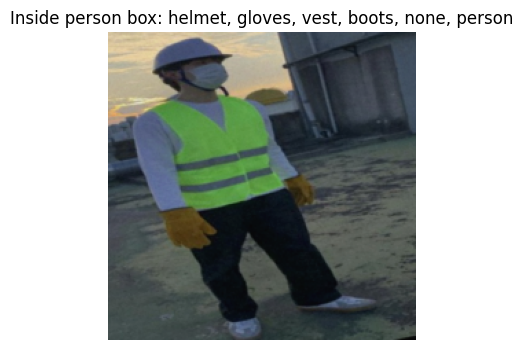

Present classes: ['helmet', 'gloves', 'vest', 'boots', 'none', 'person']


In [40]:
loader = dm.train_dataloader()

# --- fetch one batch ---
images, ys = next(iter(loader))   # images: [B,3,224,224], ys: [B,10] multi-label 0/1

# --- helper: denormalize to [0,1] for display (ImageNet stats) ---
def denormalize(img_t, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    img = img_t.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img.clamp(0, 1)

# --- pick a sample to visualize ---
k = 0  # change this index to see other samples
img = denormalize(images[k]).permute(1,2,0).cpu().numpy()

present_idxs = torch.where(ys[k] > 0.5)[0].tolist()
present_names = [CLASS_NAMES[i] for i in present_idxs]

# --- show ---
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title("Inside person box: " + (", ".join(present_names) if present_names else "None"))
plt.show()

print("Present classes:", present_names)

In [41]:
want = {"helmet": 0, "vest": 2, "goggles": 4, "gloves": 1,"person": 6}
count_hardhat = 0
count_vest = 0
count_gloves = 0
count_safe = 0
count_entries_total = 0

for batch in train_loader:
    inputs, labels = batch
    for label in labels:
        count_entries_total += 1
        if (label[want["helmet"]] == 1) and (label[want["vest"]] == 1) and (label[want["gloves"]] == 1) and (label[want["person"]] == 1):
                count_safe += 1
        if (label[want["vest"]] == 1) and (label[want["person"]] == 1):
                count_vest += 1
        if (label[want["helmet"]] == 1) and (label[want["person"]] == 1):
                count_hardhat += 1
        if (label[want["gloves"]] == 1) and (label[want["person"]] == 1):
                count_gloves += 1
    
print("FOUND")
print("with hardhat ", count_hardhat)
print("with vest ", count_vest)
print("with gloves ", count_gloves)
print("is safe ", count_safe)
print("entries total ", count_entries_total)

FOUND
with hardhat  768
with vest  761
with gloves  528
is safe  480
entries total  1067
